In [17]:
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange


$\frac{\partial T}{\partial t} - \frac{{\partial}^2 T}{\partial x^2} = 0$

$ T(t, x) = 2 + e^{-4 \pi^2 t} sin(2\pi x) + e^{-16\pi^2 t} cos(4\pi x)$, $x\in[0,1], t\in[0, 0.05]$

$\\$$T_0 = T(0, x) = 2 + sin(2\pi x) + cos(4\pi x)$

$$loss1 = 0.0005820306250825524$$

$$loss2 = 0.0003718257066793741$$

$$loss3 = 0.0008028125739656389$$

In [103]:
#define amount of sample points
N = 2000

In [104]:
def thermal_conductivity_equation(x):
    return (2 + torch.exp(-4*(torch.pi**2)*x[0])*torch.sin(2*torch.pi*x[1]) + torch.exp(-16*(torch.pi**2)*x[0])*torch.cos(4*torch.pi*x[1]))

# function depicting a real graph and a predicted one
def check_current_situation(cur_model):
    x = torch.linspace(0, 1, 100)
    time = torch.zeros(100)
    real_temp = thermal_conductivity_equation([time, x])

    test_points = torch.stack((time, x), axis = -1)

    pinn_temp = cur_model(test_points)

    plt.plot(x.detach(), pinn_temp.detach(), label='PINN prediction with t = 0')
    plt.plot(x, real_temp, label='Analytical solution with t = 0')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('T(t=0, x)')

    plt.plot()
    plt.legend()
    plt.show()

In [105]:
x_physics = torch.rand(N).requires_grad_(True)
time_physics = 0.05 * torch.rand(N).requires_grad_(True)

points_for_pinn_model = torch.stack((time_physics, x_physics), -1)
boundary_condition_points = torch.stack((torch.zeros(N), x_physics), -1)

# torch.manual_seed(123)

In [111]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 2, hidden_layer = 32, number_layers = 6, output_layer = 1):
        super().__init__()
        
        activation1 = nn.ReLU6
        self.activation2 = nn. Tanh
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation1()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        x = self.activation2(x)
        return x

In [112]:
# def loss_weights(loss_data, loss_bound, loss_phys):
#     w_bound = 0.9
#     w_data = 0.9 / (1 + np.sqrt(200) * loss_bound.detach().numpy())
#     w_phys = 0.9 / ((1 + np.sqrt(200) * loss_bound.detach().numpy()) * (1 + np.sqrt(200) * loss_data.detach().numpy()))
#     #return w_data / (w_bound + w_data + w_phys), w_bound / (w_bound + w_data + w_phys), w_phys / (w_bound + w_data + w_phys)
#     return w_data, w_bound, w_phys
def flat_the_gradient_from_loss(model, loss):
    grads = torch.autograd.grad(
        loss,
        list(model.parameters()),
        retain_graph=True,
        allow_unused=True
    )
    flat = []
    for p, g in zip(model.parameters(), grads):
        if g is None:
            flat.append(torch.zeros(p.numel(), device=p.device))
        else:
            flat.append(g.detach().reshape(-1))
    return torch.cat(flat).cpu().numpy()
def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum


    # model.zero_grad()

    return w_ic, w_pde, w_data

In [113]:
pinn_model = PINN()
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.003)
#optimizer = torch.optim.Adam(pinn_model.parameters(), lr = 0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2500, gamma=0.7)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor = 0.8)
loss_history = []

NameError: name 'activation' is not defined

In [114]:
epochs = 20000
# optimizer.param_groups[0]['lr'] = 0.003
for cur_epoch in trange(epochs):
    optimizer.zero_grad()
    
    boundary_condition_temp = pinn_model(boundary_condition_points).requires_grad_(True)
    network_temp = pinn_model(points_for_pinn_model).requires_grad_(True)
    
    # compute the "data loss"
    loss1 = torch.mean((thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - network_temp)**2).requires_grad_(True)
    loss2 = torch.mean((thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1) - boundary_condition_temp)**2).requires_grad_(True)
    
    network_temp = pinn_model(points_for_pinn_model)
    
    dt = torch.autograd.grad(network_temp, time_physics, torch.ones_like(network_temp), create_graph=True, allow_unused=False)[0]

    # compute dy/dx
    dx = torch.autograd.grad(network_temp, x_physics, torch.ones_like(network_temp), create_graph=True, allow_unused=False)[0]
    
    # compute d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True, allow_unused=False)[0]
    
    # compute the "physics loss"
    loss3 = torch.mean((dt - dx2)**2)
    dist = loss1+loss2+loss3
    # loss = 0.2*loss1 + 0.5*loss2 + 0.3*loss3 # 0.3 0.6 0.1 - good
    w2, w3, w1 = compute_weights_grad_orthogonal_autograd(
        pinn_model, loss2, loss3, loss1, kappa=2.0, eps=1e-6
    )
    # w1, w2, w3 = loss_weights(loss1, loss2, loss3)
    loss = w1*loss1 + w2*loss2 + w3*loss3
    
    loss.backward(retain_graph=True)
    loss_history.append(float(dist.detach().numpy()))
    torch.nn.utils.clip_grad_norm_(pinn_model.parameters(), max_norm=1.0)
    optimizer.step()
    #scheduler.step()
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy()), float(loss3.detach().numpy())}\t')
        print(w1, w2, w3,'\n')

  0%|          | 0/20000 [00:00<?, ?it/s]

epoch: 0	loss: (0.3505284786224365, 0.2651998996734619, 0.0806366428732872, 0.004691936541348696)	
0.18673472 0.6893706 0.12389402 

epoch: 250	loss: (0.35267430543899536, 0.2686350345611572, 0.07938798516988754, 0.004651286173611879)	
0.26718166 0.6731939 0.0596238 

epoch: 500	loss: (0.35363858938217163, 0.2651868164539337, 0.08344345539808273, 0.005008305422961712)	
0.5284716 0.40175822 0.06976981 

epoch: 750	loss: (0.3650081157684326, 0.29397961497306824, 0.06681991368532181, 0.0042085954919457436)	
0.5191759 0.44787365 0.032950003 

epoch: 1000	loss: (0.3500228226184845, 0.256544828414917, 0.08796505630016327, 0.005512912292033434)	
0.50372076 0.41954124 0.07673759 

epoch: 1250	loss: (0.35681724548339844, 0.27797505259513855, 0.07410066574811935, 0.004741529002785683)	
0.48916212 0.43890932 0.07192814 

epoch: 1500	loss: (0.3498345911502838, 0.2508643865585327, 0.09474078565835953, 0.004229420330375433)	
0.2749742 0.649074 0.07595116 

epoch: 1750	loss: (0.3569604456424713, 0.28

KeyboardInterrupt: 

# Boundary condition
## $T_0 = T(0, x) = 2 + sin(2\pi x) + cos(4\pi x)$

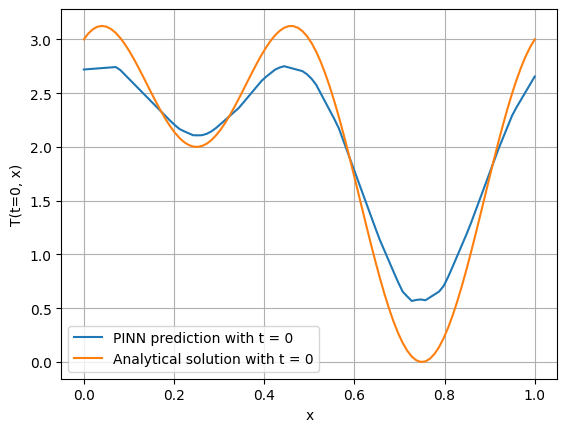

In [115]:
check_current_situation(pinn_model)

In [116]:
pinn_model(points_for_pinn_model)

tensor([[2.3804],
        [1.9920],
        [2.4034],
        ...,
        [0.6252],
        [1.4189],
        [2.1242]], grad_fn=<AddmmBackward0>)

In [117]:
torch.mean(thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - pinn_model(points_for_pinn_model))

tensor(0.0175, grad_fn=<MeanBackward0>)

In [118]:
thermal_conductivity_equation([time_physics, x_physics]).view(-1,1)


tensor([[2.1359],
        [2.0190],
        [1.9580],
        ...,
        [1.6578],
        [1.8941],
        [2.1676]], grad_fn=<ViewBackward0>)

In [119]:
torch.zeros_like(x_physics)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [120]:
x_physics

tensor([0.1590, 0.5814, 0.5369,  ..., 0.7754, 0.6317, 0.2735],
       requires_grad=True)

In [121]:
loss

tensor(0.1131, grad_fn=<AddBackward0>)

In [122]:
thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1)

tensor([[2.4269],
        [2.0321],
        [2.6643],
        ...,
        [0.0630],
        [1.1805],
        [2.0325]], grad_fn=<ViewBackward0>)

In [123]:
pinn_model(boundary_condition_points) - thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1)

tensor([[-0.0448],
        [-0.0401],
        [-0.2577],
        ...,
        [ 0.5584],
        [ 0.2358],
        [ 0.0911]], grad_fn=<SubBackward0>)

In [124]:
print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy()), float(loss3.detach().numpy())}\t')


epoch: 3031	loss: (0.3436585068702698, 0.245536208152771, 0.09277049452066422, 0.005351813975721598)	


Text(0, 0.5, 'Значение функции потерь')

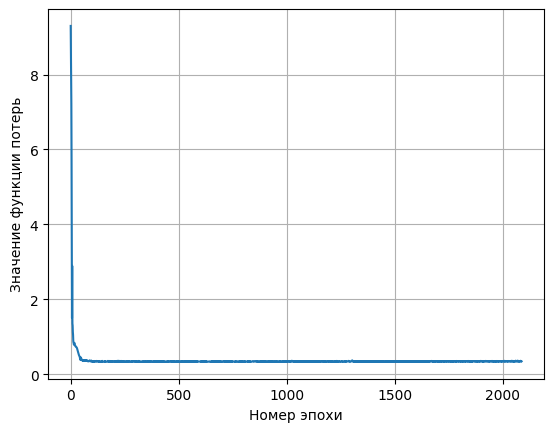

In [125]:
plt.plot(loss_history[:-3000:4])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Значение функции потерь')

In [39]:
new_loss = loss_history[::4]

In [35]:
import torch
a = torch.tensor([1.0, 2.0], requires_grad=True)
b = torch.tensor([3., 4.], requires_grad=True)
c = torch.tensor([5., 6., 7.], requires_grad=True)
t = (a @ b) * c.norm()
torch.autograd.grad(t, [a, b, c])[-1]

tensor([5.2440, 6.2929, 7.3417])

In [29]:
t

tensor(85.9128, grad_fn=<MulBackward0>)